In [1]:
#__Import libraries and script needed__
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# System and Path Libraries for Module Import
import os
import sys


# Set up the Project Path
# Add this line to your ~/.bashrc or ~/.zshrc: export REALTIMEID_PATH='/absolute/path/to/project'
project_path = os.environ.get('REALTIMEID_PATH')
if project_path and project_path not in sys.path:
    sys.path.append(project_path)
    print("Project path successfully added.")
else:
    print("Warning: 'REALTIMEID_PATH' environment variable is not set.")

# Import Custom Modules for Green's Function Kernel Analysis
from src.discr_error.discr_error import DiscrError  # Class for discretization error analysis and related functions
from src.dlr_kernel.dlr_kernel import DlrKernel  # Interpolative decomposition and utilities (e.g., effective coupling computation)
from src.utils import common_funcs as cf  # Utilities for grid generation, spectral density computations, etc.
from src.data_interpolation.data_interpolation import DataInterp
from src.utils.plot_utils import plot_data
from src.store_kernel.store_kernel import Hdf5Kernel

Project path successfully added.


In [2]:
#_____Set Parameters______

params = {
    "m": None,  # to be updated for each computation
    "n": None,  # to be updated for each computation
    "N_max": None,  # not specified as we will directly pass the time grids "times"
    "delta_t": 0.1,  #this step that we will use below to set the time grids
    "beta": np.inf,  # inverse temperature
    "upper_cutoff": np.inf,  # frequency cutoff for continous integrations
    "h": None,  # to be updated for each computation
    "phi": np.pi/4,#rotation angle in complex frequency plane
}  

#Array specifying all values for the discreitzation parameter, h, that should be evaluated
h_vals = np.log( np.arange(2., 1.0, -0.0125))  
nbr_hs = len(h_vals)

#Array specifying all values for the total number of time steps, N_max, that should be evaluated
N_maxs = np.concatenate((np.arange(20,1000,200),np.arange(1100,100,1000)))
nbr_N_maxs = len(N_maxs)

#Array specifying all values for inverse temperature, beta, that should be evaluated
betas = [0,10,20]
nbr_betas = len(betas)

#grid dimensions for grid spanned by the following array: N_maxs, h_vals and betas.
param_grid_dims = (nbr_N_maxs ,nbr_hs, nbr_betas)

In [3]:
#Define filename of hdf5 file holding the data and create Hdf5Kernel object associated with the file
name_template = '../data/beta={}_delta_t={}.h5'
filename = name_template.format(params["beta"], params["delta_t"])

#Create hdf5 file, specify the dimensions of the parameter grid
h5_kernel = Hdf5Kernel(filename=filename).create_file(kernel_dims= param_grid_dims)

In [4]:
#for each point on the parameter grid, compute the discretization error and the corresponding DlrKernel object, 
#and store in hdf5 file associated with 'h5_kernel'.
for b, beta in enumerate(betas):
    for tau, N_max in enumerate(N_maxs):

        cf.update_parameters(params, {"N_max": N_max})
        cf.update_parameters(params, {"beta": beta})

        #compute continous-frequency integral
        times = cf.set_time_grid(N_max=params["N_max"], delta_t= params["delta_t"])
        cont_integral = np.array([cf.cont_integral(t, params["beta"], params["upper_cutoff"])for t in times])  
        
        for h, h_val in enumerate(h_vals):
            
            cf.update_parameters(params, {"h": h_val})

            # Create DiscrError object which holds the error w.r.t. to the continous results, and all associated parameters.
            discr_error = DiscrError(**params, cont_integral_init=cont_integral)  
            discr_error.optimize()  # optimize values for m and n

            #Exit the loop it error is below machine precision, otherwise, append to hdf5 file
            if discr_error.eps < 1.e-14:
                break
            else:
                #create DlrKernel object based on DiscrError object
                kernel = DlrKernel(discr_error)
                #store to hdf5 file
                h5_kernel.append_kernel_element(kernel, (tau, h, b))


/Users/julianthoenniss/Documents/PhD/code/channel_IF/RealTimeID/src/utils/common_funcs.py:227: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  right_segment_cont_real, _ = integrate.quad(


In [5]:
#Extract the relevant data for plotting from hdf5 file. Assemble it conveniently into multidimensional arrays.
errors, m_vals, n_vals, h_vals, ID_ranks = h5_kernel.read_to_array()
nbr_modes_total = m_vals + n_vals

In [6]:
#Set global plot parameters
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica", "font.size": 8})
cmaps = [plt.get_cmap("Blues"), plt.get_cmap("Reds")]
colors_blue = cmaps[0](np.linspace(0.35, 0.9, len(N_maxs)))
colors_orange = cmaps[1](np.linspace(0.35, 0.9, len(N_maxs)))

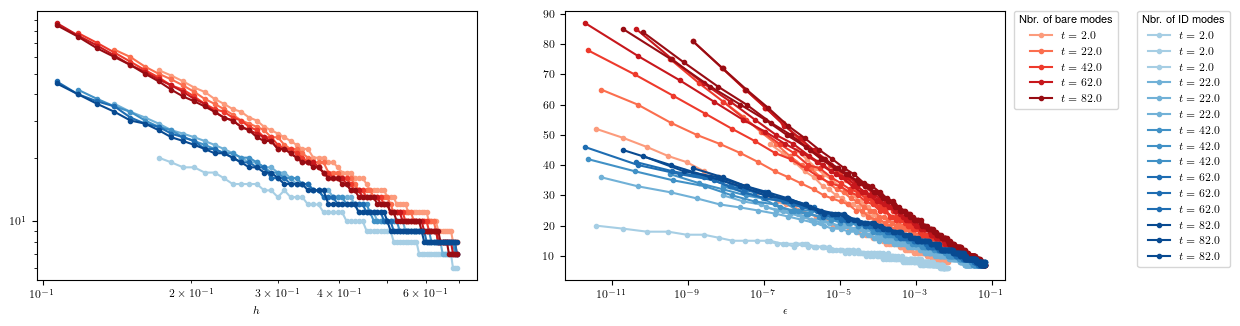

In [7]:
#_____Plot the number of modes versus the error and the discretization parameter h____
fig, axs = plt.subplots(1, 2, figsize=(12.5, 3.5))
for tau in range (len(N_maxs)):
    mask = errors[tau,:,0] > 1.e-12#mask to filter values that are zero (i.e. no value avaliable)
  
    axs[0].plot(h_vals[tau,mask,0],nbr_modes_total[tau,mask,0],color=colors_orange[tau],marker="o",linestyle="-",markersize=3, label = r'$t={}$'.format(N_maxs[tau] * params["delta_t"]))
    axs[0].plot(h_vals[tau,mask,0], ID_ranks[tau,mask,0], color=colors_blue[tau], marker="o", linestyle="-", markersize=3)

    axs[1].plot(errors[tau,mask],nbr_modes_total[tau,mask] ,color=colors_orange[tau],marker="o",linestyle="-",markersize=3)
    axs[1].plot(errors[tau,mask], ID_ranks[tau,mask], color=colors_blue[tau], marker="o", linestyle="-", markersize=3, label = r'$t={}$'.format(N_maxs[tau]* params["delta_t"]))


#x = np.linspace(1.e-8, 1.e-1)
#axs[1].plot(x, 17 * np.log(1/x), color='black', linestyle="dotted")

axs[0].set_xlabel(r"$h$")
axs[0].set_xscale("log")   
axs[0].set_yscale("log")   
axs[1].set_xlabel(r"$\epsilon$")

axs[1].set_xscale("log")


# Create legends and place them outside the rightmost subplot
legend1 = axs[0].legend(title='Nbr. of bare modes', loc='upper left', bbox_to_anchor=(2.22, 1), borderaxespad=0.)
legend2 = axs[1].legend(title='Nbr. of ID modes', loc='upper left', bbox_to_anchor=(1.3, 1), borderaxespad=0.)


#plt.savefig("../plots/modes_vs_error.pdf", bbox_inches='tight')


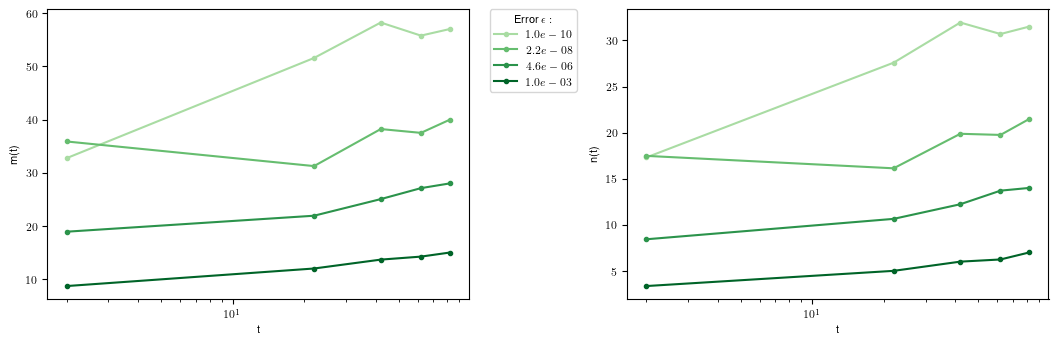

In [8]:
# Configuration and data preparation
error_grid = np.logspace(-10, -3, 4)
cmap_green = plt.get_cmap("Greens")
colors_green = cmap_green(np.linspace(0.35, 0.9, len(error_grid)))
fig, axs = plt.subplots(1, 2, figsize=(12.5, 3.5))

n_vals_interp = np.zeros((len(N_maxs), len(error_grid)))
m_vals_interp = np.zeros((len(N_maxs), len(error_grid)))

# Interpolation and plotting
for tau, t in enumerate(N_maxs):
    mask = errors[tau] > 1.e-12  # Mask to filter non-zero values
    N_VALS_INTERP = DataInterp(errors[tau, mask], n_vals[tau, mask])
    M_VALS_INTERP = DataInterp(errors[tau, mask], m_vals[tau, mask])

    n_vals_interp[tau, :] = N_VALS_INTERP.interp(error_grid, x_scale='log')
    m_vals_interp[tau, :] = M_VALS_INTERP.interp(error_grid, x_scale='log')

t_data = N_maxs * params["delta_t"]
for eps_iter, eps_val in enumerate(error_grid):
    label = f'${eps_val:.1e}$'  # Scientific notation for error values
    plot_data(axs[0], t_data[:], m_vals_interp[:, eps_iter], colors_green[eps_iter], label)
    plot_data(axs[1], t_data[:], n_vals_interp[:, eps_iter], colors_green[eps_iter], label)

# Setting labels and legend
axs[0].set_xlabel('t')
axs[0].set_ylabel('m(t)')
axs[1].set_xlabel('t')
axs[1].set_ylabel('n(t)')

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].legend(title='Error ' + r'$\epsilon:$', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to fit the legend

#plt.savefig("../plots/modes_vs_time.pdf", bbox_inches='tight')
